In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

file_name="B0005"

file_1="C:/Users/tarak/Documents/project/Battery_est_V2/"+file_name+"_dis_dataset.csv"

In [2]:
#load data
dataset=pd.read_csv(file_1)
att=["cycle","temperature_measured","capacity","current_load"]
dataset[["Soh"]]=dataset[["capacity"]]/dataset["capacity"][0]

In [3]:
Soh=dataset["capacity"]/dataset["capacity"][0]
time=dataset[["time"]]

In [4]:
# normalising data
dataset=dataset[["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load"]]
df_norm = (dataset-dataset.min())/(dataset.max()-dataset.min())
df_norm["time"]=time
df_norm["Soh"]=Soh

In [5]:
att_=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]
att=["cycle","temperature_measured","capacity","current_load"]

In [6]:
X = df_norm[att]
Y = df_norm[["Soh"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [8]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [9]:
#define lstm model we have 4 input variable so 3 layers
model = Sequential()
model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 4, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 dense (Dense)               (None, 4, 1)              6

In [10]:
model.fit(X_train, y_train, epochs=200,batch_size=20, verbose=1)

Epoch 1/200
1760/1760 [==============================] - 21s 9ms/step - loss: 0.0180
Epoch 2/200
1760/1760 [==============================] - 15s 9ms/step - loss: 0.0026
Epoch 3/200
1760/1760 [==============================] - 15s 9ms/step - loss: 0.0013
Epoch 4/200
1760/1760 [==============================] - 15s 9ms/step - loss: 4.6475e-04
Epoch 5/200
1760/1760 [==============================] - 15s 9ms/step - loss: 2.2118e-04
Epoch 6/200
1760/1760 [==============================] - 15s 9ms/step - loss: 1.7880e-04
Epoch 7/200
1760/1760 [==============================] - 15s 9ms/step - loss: 1.6537e-04
Epoch 8/200
1760/1760 [==============================] - 16s 9ms/step - loss: 1.5498e-04
Epoch 9/200
1760/1760 [==============================] - 16s 9ms/step - loss: 1.5190e-04
Epoch 10/200
1760/1760 [==============================] - 15s 9ms/step - loss: 1.4642e-04
Epoch 11/200
1760/1760 [==============================] - 16s 9ms/step - loss: 1.4350e-04
Epoch 12/200
1760/1760 [=======

1760/1760 [==============================] - 17s 9ms/step - loss: 9.1496e-05
Epoch 93/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.0941e-05
Epoch 94/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.0740e-05
Epoch 95/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.0734e-05
Epoch 96/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.1092e-05
Epoch 97/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.1331e-05
Epoch 98/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.0799e-05
Epoch 99/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.9864e-05
Epoch 100/200
1760/1760 [==============================] - 16s 9ms/step - loss: 9.0610e-05
Epoch 101/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.9745e-05
Epoch 102/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.9934e-05
Epoch 103/200
1760/1

1760/1760 [==============================] - 16s 9ms/step - loss: 8.1476e-05
Epoch 183/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0531e-05
Epoch 184/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0396e-05
Epoch 185/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0608e-05
Epoch 186/200
1760/1760 [==============================] - 16s 9ms/step - loss: 7.9930e-05
Epoch 187/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0159e-05
Epoch 188/200
1760/1760 [==============================] - 15s 9ms/step - loss: 7.9808e-05
Epoch 189/200
1760/1760 [==============================] - 18s 10ms/step - loss: 8.0098e-05
Epoch 190/200
1760/1760 [==============================] - 15s 9ms/step - loss: 7.9399e-05
Epoch 191/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0226e-05
Epoch 192/200
1760/1760 [==============================] - 16s 9ms/step - loss: 8.0060e-05
Epoch 193/20

In [11]:
y_pred_1 = model.predict(X_test, verbose=1)

472/472 [==============================] - 3s 3ms/step


In [12]:
y_pred_1

array([[[0.9967735 ],
        [0.9941873 ],
        [0.99664885],
        [0.99738383]],

       [[0.9967735 ],
        [0.99428725],
        [0.9968003 ],
        [0.9977356 ]],

       [[0.9967735 ],
        [0.9945265 ],
        [0.99714935],
        [0.9980153 ]],

       ...,

       [[0.7031807 ],
        [0.7031132 ],
        [0.712889  ],
        [0.71241605]],

       [[0.7031807 ],
        [0.7031144 ],
        [0.7128905 ],
        [0.71241367]],

       [[0.7031807 ],
        [0.7031194 ],
        [0.71289855],
        [0.7124016 ]]], dtype=float32)

In [13]:
y_pred_1=[ float(sum(i)/4) for i in y_pred_1 ]

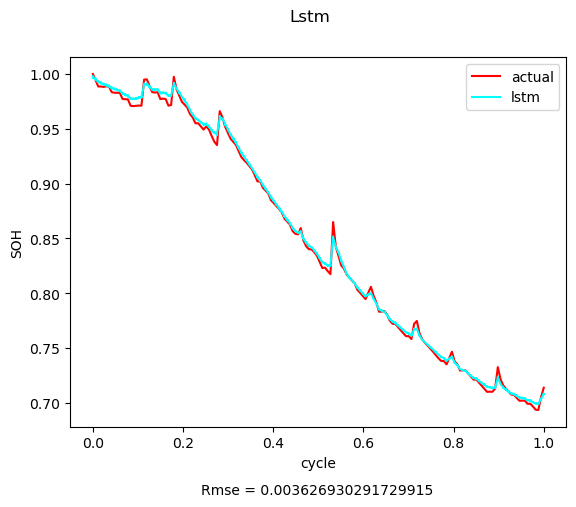

0.003626930291729915


In [14]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual')
plt.plot(X_test["cycle"],y_pred_1,color='cyan',label="lstm")
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))